In [11]:
import numpy as np
import random
import matplotlib.pyplot as plt

# Simulation parameters
T = 20                  # Total simulation time
M = 5                   # Max queue size
lambda1_peak, lambda2_peak = 3.0, 2.5  # Peak arrival rates
lambda1_offpeak, lambda2_offpeak = 1.0, 0.8  # Off-peak arrival rates
mu1, mu2 = 0.8, 1.5     # Service rates
gamma = 0.9             # Discount factor for Q-learning
overtime_threshold = 15 # Max time before overtime penalty
overtime_penalty = 5.0  # Overtime penalty per unit time
alpha = 0.1             # Q-learning learning rate
epsilon = 0.1           # Q-learning exploration rate


In [12]:
# Define possible actions
actions = ["Assign Type-1 to Server 1", "Assign Type-2 to Server 2", "Assign Type-1 to Server 2", "No action"]

# Function to determine arrival rates based on time
def dynamic_arrival_rate(time):
    if 5 <= time <= 15:  # Peak hours
        return lambda1_peak, lambda2_peak  # Higher arrival rates
    else:  # Off-peak hours
        return lambda1_offpeak, lambda2_offpeak  # Lower arrival rates


In [13]:
# Reward function to evaluate performance
def reward_function(q1, q2, b1, b2, server_time):
    idle_penalty = (b1 == 0) + (b2 == 0)  # Penalize idle servers
    waiting_penalty = q1 + q2  # Penalize waiting customers
    overtime_penalty_cost = sum(overtime_penalty if t > overtime_threshold else 0 for t in server_time)
    utilization_bonus = -0.1 * idle_penalty  # Encourage fewer idle servers
    return -(idle_penalty * 2 + waiting_penalty + overtime_penalty_cost) + utilization_bonus


In [14]:
# Q-learning policy
def q_learning_policy(Q, state):
    if random.random() < epsilon:  # Exploration
        return random.choice(actions)
    else:  # Exploitation
        return actions[np.argmax(Q[state])]

In [15]:
# State encoding
def encode_state(q1, q2, b1, b2):
    return (q1, q2, b1, b2)

In [16]:
# Simulation function
def simulate(T, M, mu1, mu2, dt, learning=True):
    # Initialising variables
    q1, q2 = 0, 0  # Initial queue lengths
    b1, b2 = 0, 0  # Server states (idle or busy)
    server_time = [0, 0]  # Time each server has been active
    total_waiting_time = 0
    total_customers_served = 0
    total_reward = 0
    server_utilization = {"Server 1": 0, "Server 2": 0}
    queue_lengths = []
    served_customers_over_time = []

    # Initialising the Q-table
    Q = {}
    for q1 in range(M + 1):
        for q2 in range(M + 1):
            for b1 in [0, 1]:
                for b2 in [0, 1]:
                    Q[encode_state(q1, q2, b1, b2)] = [0.0] * len(actions)

    print("Starting Simulation with Q-Learning:")
    time = 0
    while time < T:
        # Get current arrival rates based on time
        lambda1, lambda2 = dynamic_arrival_rate(time)
        state = encode_state(q1, q2, int(b1 > 0), int(b2 > 0))

        # Select an action using Q-learning policy
        action = q_learning_policy(Q, state)

        # Logging the current state and chosen action
        print(f"Time: {time:.1f}, Queue 1: {q1}, Queue 2: {q2}, "
              f"Server 1: {'Busy' if b1 > 0 else 'Idle'}, Server 2: {'Busy' if b2 > 0 else 'Idle'}, Action: {action}")

        # Update server utilisation metrics
        if b1 > 0:
            server_utilization["Server 1"] += dt
            server_time[0] += dt
        if b2 > 0:
            server_utilization["Server 2"] += dt
            server_time[1] += dt

        # Execute the chosen action
        if action == "Assign Type-1 to Server 1" and b1 == 0 and q1 > 0:
            q1 -= 1
            b1 = np.random.exponential(1 / mu1)
            total_customers_served += 1
        elif action == "Assign Type-2 to Server 2" and b2 == 0 and q2 > 0:
            q2 -= 1
            b2 = np.random.exponential(1 / mu2)
            total_customers_served += 1
        elif action == "Assign Type-1 to Server 2" and b2 == 0 and q1 > 0:
            q1 -= 1
            b2 = np.random.exponential(1 / mu2)
            total_customers_served += 1

        # Calculate the reward
        reward = reward_function(q1, q2, b1 > 0, b2 > 0, server_time)
        total_reward += reward

        # Update Q-values
        if learning:
            next_state = encode_state(q1, q2, int(b1 > 0), int(b2 > 0))
            Q[state][actions.index(action)] += alpha * (
                reward
                + gamma * max(Q[next_state])
                - Q[state][actions.index(action)]
            )

        # Handle customer arrivals
        if random.random() < lambda1 * dt:
            q1 = min(q1 + 1, M)
        if random.random() < lambda2 * dt:
            q2 = min(q2 + 1, M)

        # Process service completions
        if b1 > 0:
            b1 = max(0, b1 - dt)
        if b2 > 0:
            b2 = max(0, b2 - dt)

        # Update total waiting time and logs
        total_waiting_time += (q1 + q2) * dt
        time += dt
        queue_lengths.append((q1, q2))
        served_customers_over_time.append(total_customers_served)

    # Calculate final utilisation
    utilization_1 = server_utilization["Server 1"] / T
    utilization_2 = server_utilization["Server 2"] / T
    print("\nSimulation Summary:")
    print(f"Total Customers Served: {total_customers_served}")
    print(f"Total Waiting Time: {total_waiting_time:.2f}")
    print(f"Server 1 Utilisation: {utilization_1:.2%}")
    print(f"Server 2 Utilisation: {utilization_2:.2%}")
    print(f"Total Reward: {total_reward:.2f}")

    return queue_lengths, served_customers_over_time, server_utilization


In [17]:
# Time step
dt = 0.1  # Time step for simulation

# Run simulation
queue_lengths, served_customers_over_time, server_utilization = simulate(T, M, mu1, mu2, dt)


Starting Simulation with Q-Learning:
Time: 0.0, Queue 1: 5, Queue 2: 5, Server 1: Busy, Server 2: Busy, Action: Assign Type-1 to Server 1
Time: 0.1, Queue 1: 5, Queue 2: 5, Server 1: Busy, Server 2: Busy, Action: Assign Type-2 to Server 2
Time: 0.2, Queue 1: 5, Queue 2: 5, Server 1: Busy, Server 2: Busy, Action: Assign Type-1 to Server 2
Time: 0.3, Queue 1: 5, Queue 2: 5, Server 1: Busy, Server 2: Busy, Action: No action
Time: 0.4, Queue 1: 5, Queue 2: 5, Server 1: Busy, Server 2: Busy, Action: Assign Type-1 to Server 1
Time: 0.5, Queue 1: 5, Queue 2: 5, Server 1: Busy, Server 2: Busy, Action: Assign Type-2 to Server 2
Time: 0.6, Queue 1: 5, Queue 2: 5, Server 1: Busy, Server 2: Busy, Action: Assign Type-1 to Server 2
Time: 0.7, Queue 1: 5, Queue 2: 5, Server 1: Busy, Server 2: Busy, Action: No action
Time: 0.8, Queue 1: 5, Queue 2: 5, Server 1: Busy, Server 2: Busy, Action: Assign Type-1 to Server 1
Time: 0.9, Queue 1: 5, Queue 2: 5, Server 1: Busy, Server 2: Busy, Action: Assign Type

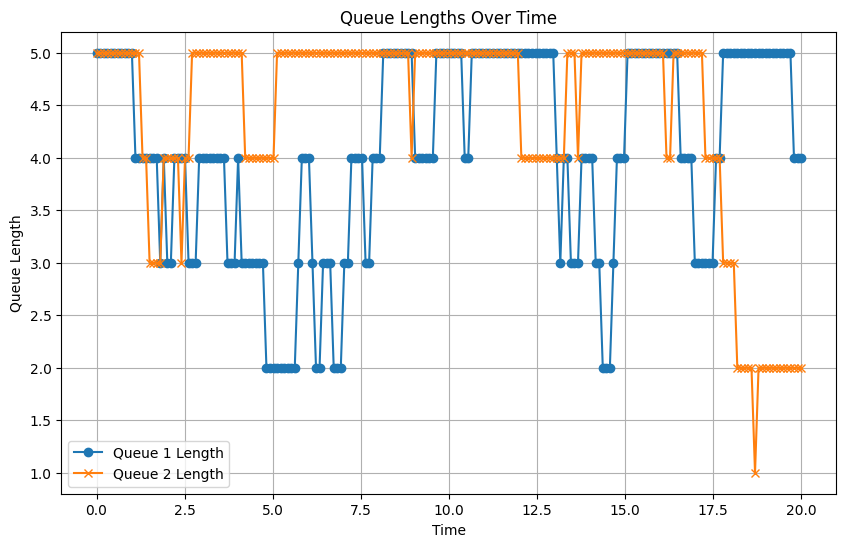

In [18]:
# Extract data for plotting
time_points = np.linspace(0, T, len(queue_lengths))
q1_lengths = [q[0] for q in queue_lengths]
q2_lengths = [q[1] for q in queue_lengths]

# Plot Queue Lengths
plt.figure(figsize=(10, 6))
plt.plot(time_points, q1_lengths, label="Queue 1 Length", linestyle='-', marker='o')
plt.plot(time_points, q2_lengths, label="Queue 2 Length", linestyle='-', marker='x')
plt.xlabel("Time")
plt.ylabel("Queue Length")
plt.legend()
plt.title("Queue Lengths Over Time")
plt.grid()
plt.show()




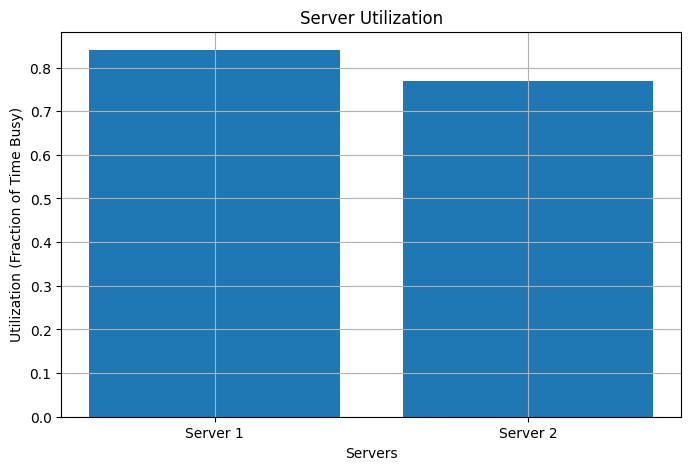

In [19]:
# Plot Server Utilization
plt.figure(figsize=(8, 5))
plt.bar(["Server 1", "Server 2"], [server_utilization["Server 1"] / T, server_utilization["Server 2"] / T])
plt.xlabel("Servers")
plt.ylabel("Utilization (Fraction of Time Busy)")
plt.title("Server Utilization")
plt.grid()
plt.show()


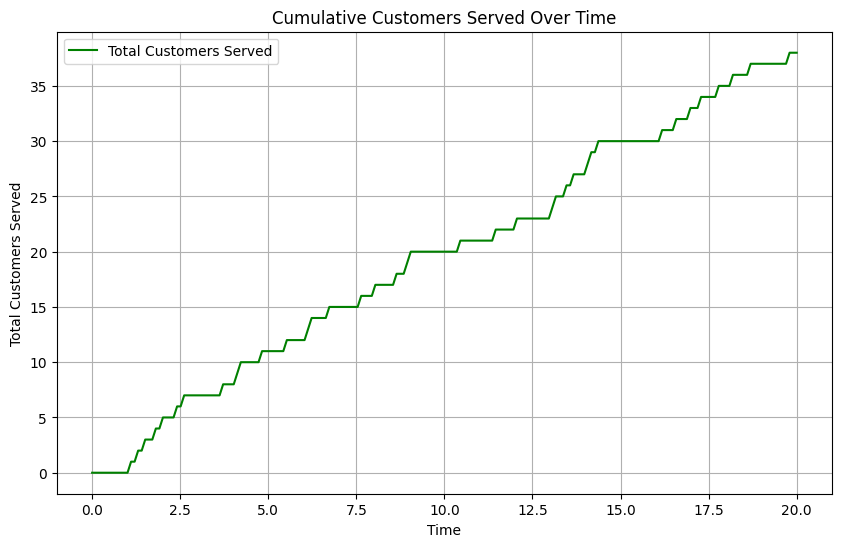

In [20]:

# Plot Cumulative Customers Served Over Time
plt.figure(figsize=(10, 6))
plt.plot(time_points, served_customers_over_time, label="Total Customers Served", color='green')
plt.xlabel("Time")
plt.ylabel("Total Customers Served")
plt.legend()
plt.title("Cumulative Customers Served Over Time")
plt.grid()
plt.show()